In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from glob import glob
import html2text
import requests
from collections import defaultdict
import networkx as nx

## Loading Data

In [2]:
# load data
filenames = glob("data/interim/df_*.csv")
dataframes = [pd.read_csv(f, encoding='latin-1') for f in filenames]

In [3]:
for i in range(17):
    dataframes[i] = dataframes[i].drop('Unnamed: 0', axis=1)

## Functions to create documents

In [4]:
# takes a post id and returns a dataframe with that post
def getPost(id):
    
    # define dataframe structure in memory
    df = pd.DataFrame(columns=['by', 'score', 'time', 'timestamp', 'title', 'type', 'url', 'text',
       'parent', 'deleted', 'dead', 'descendants', 'id', 'ranking'])
    
    # find the post and add it to the dataframe in memory
    for dataframe in dataframes:
        df = pd.concat([dataframe[dataframe["id"] == id], df])
        
    return df

In [5]:
# takes a list of post ids and returns the comments on those posts
def getComments(parents, family=None):
    
    # define dataframe structure in memory
    children = pd.DataFrame(columns=['by', 'score', 'time', 'timestamp', 'title', 'type', 'url', 'text',
       'parent', 'deleted', 'dead', 'descendants', 'id', 'ranking'])
    
    # store family
    fam = family
    
    # base case: if no parents provided, return the family
    if not parents:
        return fam
    
    # recursive case: if parents provided, add children to family and check next generation
    else:
        
        # define the next generation
        nextgen = []
        
        # for each dataframe
        for dataframe in dataframes:

            # add the parent's children to the next generation
            children = pd.concat([dataframe[dataframe["parent"].isin(parents)], children]) 
            nextgen += list(children["id"])

            # add the parent's children to the family
            fam = pd.concat([children, fam])

            # reset children for the next parent
            children = pd.DataFrame(columns=['by', 'score', 'time', 'timestamp', 'title', 'type', 'url', 'text',
   'parent', 'deleted', 'dead', 'descendants', 'id', 'ranking'])

        # return getThread on the next generation and current family
        return getComments(nextgen, fam)        

In [6]:
def getThread(id):
    return pd.concat([getPost(id), getComments([id])])

In [7]:
def makeDocument(id):
    return html2text.html2text(" ".join(list(getThread(id)["text"].dropna())))

In [8]:
def computeDescendants(thread):
    thread = thread.reset_index(drop=True)
    
    thread["count"] = 1
    
    sums = thread.groupby("parent").sum().reset_index()[["parent", "count"]]
    
    descendants = pd.merge(thread, sums, how="left", left_on="id", right_on="parent")
    
    descendants = descendants["count_y"].fillna(0).astype(int)
    
    thread["descendants"] = descendants
    
    return thread

In [9]:
def getMostRecentPostsBy(user):
    url = "https://hacker-news.firebaseio.com/v0/user/" + user + ".json"
    response = requests.get(url, data=data)
    comments = response.json()["submitted"][0:3]
    
    posts = []
    
    for comment in comments:
        url = "https://hacker-news.firebaseio.com/v0/item/" + str(comment) + ".json"
        response = requests.get(url, data=data)
        posts += [response.json()["text"]]
        
    return posts

## Can Discussion Threads by Categorized by the content of the comments?

In [245]:
# define test documents
sexism = [14988086, 3739913, 14967505]
selfDriving = [15644680, 13718586, 14338328]
augmentedReality = [15124809, 14490239, 14713679]

corpus = [makeDocument(id) for id in sexism + selfDriving + augmentedReality]

#### Find Descriptive Words and Add them to a defaultdict of documents

In [276]:
# find our most descriptive words!
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df=0, stop_words='english')

tfidf_matrix = tf.fit_transform(corpus)
feature_names = tf.get_feature_names()
dense_matrix = tfidf_matrix.todense()
num_documents = len(corpus)

docs_and_scores = defaultdict(list)

for i in np.arange(num_documents):
    document_words = dense_matrix[i].tolist()[0]
    document_scores = [pair for pair in zip(range(0, len(document_words)), document_words) if pair[1] > 0]
    
    sorted_scores = sorted(document_scores, key=lambda t: t[1] * -1)[0:4] #4 words
    
    print("Top words in document {}".format(i + 1))
    for scores_tuple in sorted_scores:
        
        
        docs_and_scores[i+1].append((feature_names[scores_tuple[0]], round(scores_tuple[1], 5)))
        print("\tWord: {}, TF-IDF: {}".format(feature_names[scores_tuple[0]], round(scores_tuple[1], 5)))


Top words in document 1
	Word: women, TF-IDF: 0.54375
	Word: men, TF-IDF: 0.25293
	Word: people, TF-IDF: 0.19437
	Word: gender, TF-IDF: 0.15769
Top words in document 2
	Word: women, TF-IDF: 0.58869
	Word: sexism, TF-IDF: 0.31297
	Word: men, TF-IDF: 0.188
	Word: sexist, TF-IDF: 0.14904
Top words in document 3
	Word: women, TF-IDF: 0.37567
	Word: people, TF-IDF: 0.23805
	Word: salary, TF-IDF: 0.22809
	Word: memo, TF-IDF: 0.17746
Top words in document 4
	Word: car, TF-IDF: 0.51751
	Word: driving, TF-IDF: 0.31626
	Word: cars, TF-IDF: 0.24394
	Word: waymo, TF-IDF: 0.19838
Top words in document 5
	Word: google, TF-IDF: 0.31002
	Word: uber, TF-IDF: 0.30372
	Word: laptop, TF-IDF: 0.20177
	Word: waymo, TF-IDF: 0.19056
Top words in document 6
	Word: uber, TF-IDF: 0.51213
	Word: lyft, TF-IDF: 0.49522
	Word: driving, TF-IDF: 0.2002
	Word: drivers, TF-IDF: 0.16827
Top words in document 7
	Word: apple, TF-IDF: 0.34026
	Word: ar, TF-IDF: 0.34021
	Word: android, TF-IDF: 0.33848
	Word: ios, TF-IDF: 0.2

#### Compute edges as product of descriptive word scores

In [277]:
edges = []

for u in range(1, len(docs_and_scores)+1):
    set1 = set([i[0] for i in docs_and_scores[u]])
    for v in range(u+1, len(docs_and_scores)+1):
        set2 = set([i[0] for i in docs_and_scores[v]])
        
        keyword_intersections = set1.intersection(set2)        
        
        for word in keyword_intersections:
            
            score1 = dict(docs_and_scores[u])[word]
            score2 = dict(docs_and_scores[u])[word]
            
            weight = score1 * score2

            edges.append((u, v, word, weight))
            
edges

[(1, 2, 'men', 0.06397358489999999),
 (1, 2, 'women', 0.29566406249999994),
 (1, 3, 'people', 0.03777969689999999),
 (1, 3, 'women', 0.29566406249999994),
 (2, 3, 'women', 0.3465559161),
 (4, 5, 'waymo', 0.0393546244),
 (4, 6, 'driving', 0.1000203876),
 (5, 6, 'uber', 0.09224583839999999),
 (7, 8, 'apple', 0.1157768676),
 (7, 8, 'ar', 0.1157428441),
 (7, 9, 'ar', 0.1157428441),
 (8, 9, 'ar', 0.41478752159999993)]

### Create and draw graph of corpus

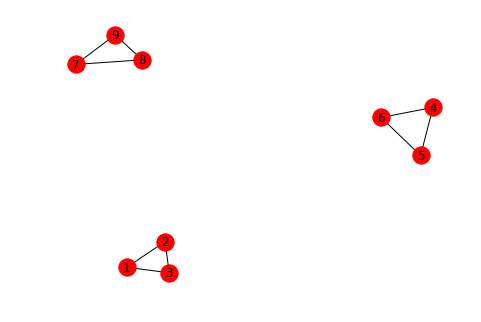

In [295]:
G = nx.Graph()

G.add_nodes_from(list(docs_and_scores.keys()))

for edge in edges:
    G.add_edge(edge[0], edge[1], key=edge[2], weight=edge[3])

nx.draw(G, with_labels=True)
plt.show()

### Finding the most provocative users in each topic

In [14]:
def makeTopicDf(topicIdList):
    return pd.concat([computeDescendants(getThread(id)) for id in topicIdList])

In [15]:
def getProvocativeCommenters(df):
    df = df[df.type != "story"]
    df = df.groupby("by").sum()
    df["avg"] = df["descendants"] / df["count"]
    df = df[df["count"] > 2]
    return df.sort_values(by="avg", ascending=False)    

In [16]:
getProvocativeCommenters(makeTopicDf(selfDriving)).head()

,score,time,descendants,ranking,count,avg
by,,,,,,
aidenn0,NaN,4.530410e+09,12,NaN,3,4.00
nodesocket,NaN,5.979329e+09,13,NaN,4,3.25
xt00,NaN,4.463675e+09,9,NaN,3,3.00
CPLX,NaN,4.477572e+09,9,NaN,3,3.00
keeptrying,NaN,4.484538e+09,9,NaN,3,3.00


In [17]:
getProvocativeCommenters(makeTopicDf(sexism)).head()

,score,time,descendants,ranking,count,avg
by,,,,,,
imartin2k,NaN,6.009886e+09,19,NaN,4,4.750000
rayiner,NaN,6.009309e+09,17,NaN,4,4.250000
josteink,NaN,6.009134e+09,12,NaN,4,3.000000
trentnix,NaN,4.506852e+09,8,NaN,3,2.666667
huffmsa,NaN,1.041999e+10,14,NaN,7,2.000000


In [18]:
getProvocativeCommenters(makeTopicDf(augmentedReality)).head()

,score,time,descendants,ranking,count,avg
by,,,,,,
prophesi,NaN,4.512089e+09,8,NaN,3,2.666667
greenscale,NaN,4.498125e+09,8,NaN,3,2.666667
sillysaurus3,NaN,5.997632e+09,10,NaN,4,2.500000
sidlls,NaN,7.520153e+09,12,NaN,5,2.400000
rsp1984,NaN,6.016123e+09,9,NaN,4,2.250000


# Bringing it together: Recommending Blockchain content

### Simulating a corpus

In [19]:
# bootstrap a topic by filling it with algolia search results
blockchain = [16145451, 15509147, 15935179, 15605753, 16617136, 14945008, 15203314, 15400963, 15008634, 15919650, 15882877, 15935342, 16035387, 14824695, 14894906, 15870468, 15347578, 15817510, 14548805, 16122776, 16004945, 14795457, 14495623, 15136222, 14623821, 14901900, 14705499, 14981556, 15831713, 15299359, 14730354, 14865868, 14434244, 15479945, 15840594, 16269444, 16622245, 15172617, 14850806, 16435294, 16598210, 15398550, 16107597, 15945490, 15497729, 15372940, 16584755, 15979024, 14430690, 15588380, 16358102, 16205776, 15994571, 15404601, 14439789, 16191506, 15058698, 14552030, 16315456, 16674387, 16545023, 15569325, 15264169, 16256472, 14573959, 15436592, 14317971, 14897774, 15103007, 14758516, 15998861, 14332397, 15540833, 16537377, 15021711, 15644545, 15178093, 14802154, 15984946, 15306223, 14434405, 15522023, 16235886, 14825095, 15950179, 14774263, 15430668, 16244668, 16201007, 16628067, 16421383, 15298300, 16089069, 16017319, 14534352, 15529512, 14671346, 14475733, 14926380, 15614231, 14594172, 15988709, 15016080, 15024823, 15479091, 15382911, 16161641, 14644820, 15850949, 15915520, 16115891, 16468714, 14236945, 16017978, 15057985, 14361918]

In [20]:
blockchain_df = makeTopicDf(blockchain)
blockchain_commenters = getProvocativeCommenters(blockchain_df)

In [21]:
blockchain_commenters.head()

,score,time,descendants,ranking,count,avg
by,,,,,,
victor106,NaN,4.530126e+09,15,NaN,3,5.000000
lumberjack,NaN,6.015430e+09,17,NaN,4,4.250000
davesque,NaN,4.553854e+09,11,NaN,3,3.666667
programmarchy,NaN,4.515940e+09,11,NaN,3,3.666667
joshfraser,NaN,4.544610e+09,11,NaN,3,3.666667


### Fetching Latest Posts by top users

In [22]:
# use the live HN api to grab the latest post by users
def getLatestPostBy(user):
    url = "https://hacker-news.firebaseio.com/v0/user/" + str(user) + ".json"
    response = requests.get(url, data=0)
    
    recentPost = max(response.json()["submitted"])
    
    url = "https://hacker-news.firebaseio.com/v0/item/" + str(recentPost) + ".json"
    response = requests.get(url, data=0)

    
    return response.json()

In [23]:
blockchain_provocateurs = list(blockchain_commenters.index)[0:5]

In [24]:
getLatestPostBy("lumberjack")

{'by': 'lumberjack',
 'id': 16687489,
 'kids': [16689329],
 'parent': 16686488,
 'text': 'There are some niches where you can invest in some $100k equipment and then basically just lease it out to people, or operate a very simple business where all you do is operate the equipment.<p>Some examples:\n- cutting prescription lenses\n- power washing&#x2F;landscaping equipment\n- food carts\n- printing T-Shirts\n- plotters&#x2F;CNC machines&#x2F;3D printers<p>I know a few people who run side businesses where all they did was buy the equipment and hire one employee to operate it.',
 'time': 1522152509,
 'type': 'comment'}

### Recommending Threads to Explore

In [26]:
links = []

for user in blockchain_provocateurs:
    thread = getLatestPostBy(user)
    url = "https://news.ycombinator.com/item?id=" + str(thread["parent"])
    links.append(url)
    
print("Provocative Blockchain Posters are Commenting here:")
for link in set(links):
    print(link)

Provocative Blockchain Posters are Commenting here:
https://news.ycombinator.com/item?id=16621384
https://news.ycombinator.com/item?id=16556468
https://news.ycombinator.com/item?id=16668172
https://news.ycombinator.com/item?id=16686488
https://news.ycombinator.com/item?id=16691141
